In [89]:
import scipy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#### *Load Network Topology*

In [90]:
# Load the .mat file
mat_data = scipy.io.loadmat(r'E:\University\Master\Project\Codes\6D-MAN\MAN157Nodes.mat')

# Display the keys in the loaded dictionary
print(mat_data.keys())

net_topology = mat_data['MAN157Nodes']
net_topology_ex = net_topology.copy()

print('the type of net_topology:', type(net_topology_ex))

topo_size = net_topology_ex.shape
print('the shape of net_topology: ', topo_size)

dict_keys(['__header__', '__version__', '__globals__', 'MAN157Nodes'])
the type of net_topology: <class 'numpy.ndarray'>
the shape of net_topology:  (157, 157)


In [91]:
# Make the adjacenccy matrix upper triangular
net_topology_ex = np.triu(net_topology_ex)

In [92]:
# Create graph from adjacency matrix
net_graph = nx.from_numpy_array(net_topology_ex)

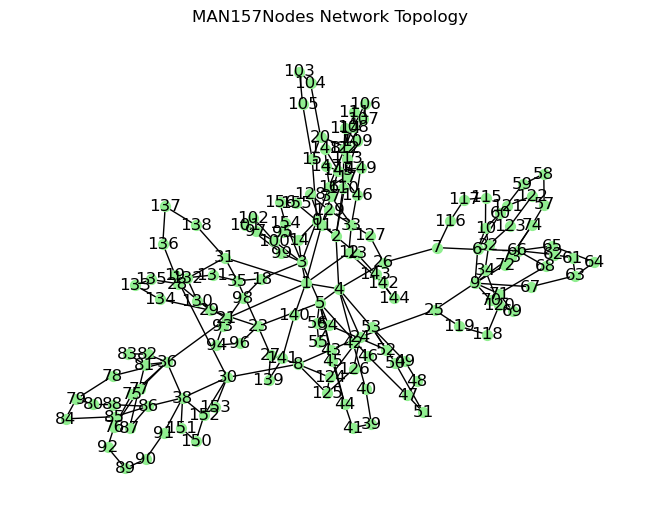

In [93]:
# Draw the graph
nx.draw(net_graph, pos = nx.spring_layout(net_graph), with_labels = True, node_color = 'lightgreen', node_size = 50)
plt.title('MAN157Nodes Network Topology')
plt.show()

#### *Extract all source-destination-weight pairs*

In [94]:
src_des_weight = list(G.edges(data = 'weight'))
src_des_weight_matrix = np.array(src_des_weight)

print('the shape of source-destination-weight matrix:', src_des_weight_matrix.shape)

the shape of source-destination-weight matrix: (220, 3)


##### *Some statistical analysis of links*

In [107]:
num_links = src_des_weight_matrix.shape[0]

print('number of links:', num_links)
print('maximum link weight:', src_des_weight_matrix[:, 2].max())
print('maximum link weight:', src_des_weight_matrix[:, 2].min())
print('average link weight:', src_des_weight_matrix[:, 2].mean())

number of links: 220
maximum link weight: 65.67
maximum link weight: 0.7
average link weight: 11.137363636363638


##### *Calculate the number of optical amplifier spans required for signal transmission*

In [96]:
# Define span length of 70 km
span_length = 70

# Calculate the number of spans required for each link
num_spans_per_link = np.ceil(src_des_weight_matrix[:, 2] / span_length)

#### *Node categorization into hierarchical levels*

In [97]:
# manually assign nodes 2 and 6 into HL1 level
HL1_StandAlone = np.array([1, 5])

# manually assign nodes [0 2 3 4] into HL1 level
HL2_StandAlone = np.array([0, 2, 3, 4])

# manually assign nodes 6 to 38 into HL1 level
HL3_StandAlone = np.arange(6, 39)

# manually assign nodes 39:topo_size(1) into HL1 level
HL4_StandAlone = np.arange(39, topo_size[1])

# concatenated HL1, HL2, HL3 nodes
HL123_standalone = np.concatenate((HL1_StandAlone, HL2_StandAlone, HL3_StandAlone))

# there is a colocated HL4 router in each upper level routers (HL1, HL2, HL3)
HL4_colocated = np.sort(HL123_standalone)

# concatenate all HL4 nodes consist of standalone and colocated
HL4_all = np.concatenate((HL4_colocated, HL4_StandAlone))

# there is colocated HL3 routers in HL1 and HL2 nodes
HL3_colocated = np.concatenate((HL1_StandAlone, HL2_StandAlone))

# there is colocated HL2 routers in HL1 nodes
HL2_colocated = HL1_StandAlone

##### *Calculate node degree of each hierarchical level nodes*


In [115]:
# calculate HLx subnet graphs
HL4_subgraph = net_graph.subgraph(HL4_StandAlone).copy() # HL4 subnet graph
HL3_subgraph = net_graph.subgraph(HL3_StandAlone).copy() # HL3 subnet graph
HL2_subgraph = net_graph.subgraph(HL2_StandAlone).copy() # HL2 subnet graph
HL1_subgraph = net_graph.subgraph(HL1_StandAlone).copy() # HL1 subnet graph

# calculate node degree of different HLx
HL4_degrees = np.array(net_graph.degree(HL4_StandAlone))
HL3_degrees = np.array(net_graph.degree(HL3_StandAlone))
HL2_degrees = np.array(net_graph.degree(HL2_StandAlone))
HL1_degrees = np.array(net_graph.degree(HL1_StandAlone))

In [114]:
HL4_degrees.max(axis = 0)

array([156,   5])

##### *Some statistical analysis of node degrees*

In [122]:
print('maximum node degree of HL4 routers:', HL4_degrees.max(axis = 0)[1])
print('minimum node degree of HL4 routers:', HL4_degrees.min(axis = 0)[1])
print('average node degree of HL4 routers:', HL4_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')

print('maximum node degree of HL3 routers:', HL3_degrees.max(axis = 0)[1])
print('minimum node degree of HL3 routers:', HL3_degrees.min(axis = 0)[1])
print('average node degree of HL3 routers:', HL3_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')

print('maximum node degree of HL2 routers:', HL2_degrees.max(axis = 0)[1])
print('minimum node degree of HL2 routers:', HL2_degrees.min(axis = 0)[1])
print('average node degree of HL2 routers:', HL2_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')

print('maximum node degree of HL1 routers:', HL1_degrees.max(axis = 0)[1])
print('minimum node degree of HL1 routers:', HL1_degrees.min(axis = 0)[1])
print('average node degree of HL1 routers:', HL1_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')


maximum node degree of HL4 routers: 5
minimum node degree of HL4 routers: 2
average node degree of HL4 routers: 2.2711864406779663
-----------------------------------------------------------------
maximum node degree of HL3 routers: 8
minimum node degree of HL3 routers: 3
average node degree of HL3 routers: 3.9393939393939394
-----------------------------------------------------------------
maximum node degree of HL2 routers: 8
minimum node degree of HL2 routers: 5
average node degree of HL2 routers: 6.75
-----------------------------------------------------------------
maximum node degree of HL1 routers: 8
minimum node degree of HL1 routers: 7
average node degree of HL1 routers: 7.5
-----------------------------------------------------------------
